**Forecasting Using a Sequence-to-Sequence Model:**
- Instead of training the model to forecast the next 14 values only at the very last timestep, we can train it to forecast the next 14 values at each and every timestep. In otherwords, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. The advantage being that the loss will contain a term for the output of the RNN at each and every timestep, not just the output at the last timestep.
- Implying that there will be more error gradients flowing through the model, and they won't have to flow through time as much since they will come from the output of each timestep, not just the last one
- To be clear, at timestep 0, the model will output a vector containing the forecasts for timesteps 1 to 14, then, at timestep 1 the forecast from timesteps 2 to 15, and so on. The targets are sequences of consecutive windows, shifted by one timestep at each timestep. The target isn't a vector anymore, but a sequence of the same length as the inputs, containing a 14-dimensional vector at each step.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
from utils.fetch_data import fetch_timeseries_data
from utils.load_data import TimeSeriesDataset
import utils.train_model as train_mod
import importlib
importlib.reload(train_mod)
train_oned = train_mod.train_oned
import importlib
import utils.fetch_data as fetch_data
importlib.reload(fetch_data)
create_splits = fetch_data.create_splits
create_oned_chunks = fetch_data.create_oned_chunks
from utils.early_stopping import EarlyStopping

In [51]:
importlib.reload(train_mod)
train_oned2 = train_mod.train_oned2

Get the data:

In [2]:
df = fetch_timeseries_data()

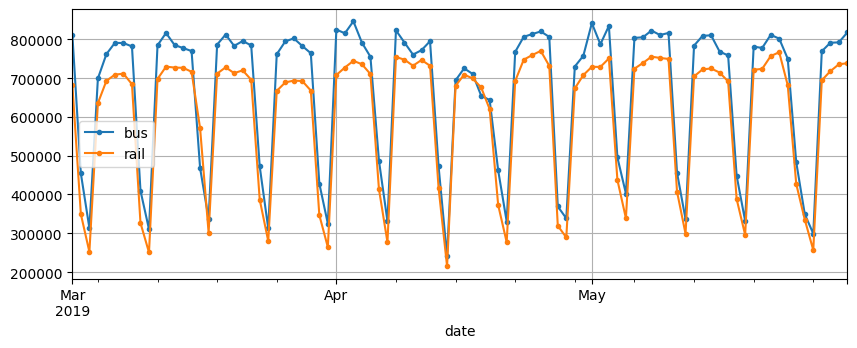

In [3]:
df['2019-03':'2019-05'].plot(grid=True, marker='.',figsize=(10,3.5))
plt.show()

In [4]:
torch.manual_seed(1)

In [5]:
rail_train, rail_valid, rail_test = create_splits(df)

In [6]:
rail_train

date
2016-01-01    0.319835
2016-01-02    0.365509
2016-01-03    0.287661
2016-01-04    0.703185
2016-01-05    0.727716
                ...   
2018-12-27    0.453029
2018-12-28    0.493961
2018-12-29    0.307105
2018-12-30    0.265310
2018-12-31    0.386058
Name: rail, Length: 1096, dtype: float64

In [7]:
rail_train.values

array([0.319835, 0.365509, 0.287661, ..., 0.307105, 0.26531 , 0.386058],
      shape=(1096,))

In [8]:
train_x_chunks = [rail_train.values.tolist()[i:i+56] for i in range(len(rail_train.values.tolist())-56-14+1)]

In [9]:
torch.tensor(train_x_chunks).shape

torch.Size([1027, 56])

In [10]:
train_y_chunks = []

for i in range(len(rail_train.values.tolist())-56-14+1):
    train_y_chunks.append([rail_train.values.tolist()[i+j+1:i+j+1+14] for j in range(56)])

In [11]:
torch.tensor(train_y_chunks).shape

torch.Size([1027, 56, 14])

In [12]:
torch.tensor(train_x_chunks)[1026]

tensor([0.7936, 0.7959, 0.8028, 0.7778, 0.4355, 0.3152, 0.7661, 0.7850, 0.7764,
        0.7983, 0.7543, 0.4285, 0.2913, 0.7702, 0.7647, 0.7832, 0.7973, 0.7514,
        0.3857, 0.3047, 0.6522, 0.7692, 0.7662, 0.7649, 0.7832, 0.4537, 0.3160,
        0.7402, 0.7415, 0.6054, 0.1965, 0.3932, 0.3480, 0.2470, 0.6471, 0.7424,
        0.7498, 0.7646, 0.7605, 0.3591, 0.2852, 0.7311, 0.7457, 0.7370, 0.7571,
        0.7314, 0.3997, 0.2917, 0.7065, 0.7311, 0.7271, 0.7380, 0.7242, 0.4251,
        0.3093, 0.6680])

In [13]:
torch.tensor(train_y_chunks)[1026,0,:]

tensor([0.7959, 0.8028, 0.7778, 0.4355, 0.3152, 0.7661, 0.7850, 0.7764, 0.7983,
        0.7543, 0.4285, 0.2913, 0.7702, 0.7647])

In [14]:
torch.tensor(train_y_chunks)[1026,54,:]

tensor([0.6680, 0.7019, 0.7008, 0.6820, 0.6335, 0.3394, 0.2601, 0.2793, 0.1280,
        0.4120, 0.4530, 0.4940, 0.3071, 0.2653])

In [15]:
train_x_chunks = torch.tensor(train_x_chunks)
train_y_chunks = torch.tensor(train_y_chunks)

Done it => successfully come up with a method of forming tensors for sequence to sequence timeseries training.

need to do it for the validation and test sets now:

In [16]:
valid_x_chunks = torch.tensor([rail_valid.values.tolist()[i:i+56] for i in range(len(rail_valid.values.tolist())-56-14+1)])
valid_x_chunks.shape

torch.Size([82, 56])

- essentially, what we've created with valid_x_chunks an array of shape: batch_size x seq_length. We iterated through the entire dataset, generating sequences of length 56, and making sure not to go past the point where we can't perfectly form sequences of length 56 - hence justifying the (-56 from the range). Also, need to ensure that the final 14 values to be predicted (14 future values since we are building a model to forecast 14 timesteps ahead in oneshot - do not appear in the last batch's x values - so as to avoid data leakage). 
- Now using that context and information we create the y chunks as well: we ensure we have the same batch size as the original x chunks, so we iterate through the same length of inputs. then -> remember that for the y chunks we are trying to create chunks of shape: (batch_size, sequence_length, 14 timesteps). so for each timestep we lool through, we need to come up with a tensor of shape [56,14]. so for each timestep - we have another internal loop, looping through 56 values, and each time we do so, get the next 14 future values

In [17]:
valid_y_chunks = []

# think of this loop 
for i in range(len(rail_valid.values.tolist())-56-14+1):
    valid_y_chunks.append([rail_valid.values.tolist()[i+j+1:i+j+1+14] for j in range(56)])

In [18]:
valid_y_chunks = torch.tensor(valid_y_chunks)
valid_y_chunks.shape

torch.Size([82, 56, 14])

Do it for the test set:

In [19]:
test_x_chunks = torch.tensor([rail_test.values.tolist()[i:i+56] for i in range(len(rail_test.values.tolist())-56-14+1)])
test_x_chunks.shape

torch.Size([2215, 56])

In [20]:
test_y_chunks = []

for i in range(len(rail_test.values.tolist())-56-14+1):
    test_y_chunks.append([rail_test.values.tolist()[i+j+1:i+j+1+14] for j in range(56)])

test_y_chunks = torch.tensor(test_y_chunks)
test_y_chunks.shape

torch.Size([2215, 56, 14])

Batch the data:

In [23]:
train_x_chunks.shape, train_y_chunks.shape

(torch.Size([1027, 56]), torch.Size([1027, 56, 14]))

In [32]:
class SequenceDataset(Dataset):
    def __init__(self, x_chunks, y_chunks):
        self.x_chunks = x_chunks.unsqueeze(2)
        self.y_chunks = y_chunks
    def __len__(self):
        return self.x_chunks.shape[0]
    
    def __getitem__(self, index):
        c_x = self.x_chunks[index]
        c_y = self.y_chunks[index]
        return c_x, c_y

In [36]:
train_ds = SequenceDataset(train_x_chunks, train_y_chunks)
val_ds = SequenceDataset(valid_x_chunks, valid_y_chunks)
test_ds = SequenceDataset(test_x_chunks, test_y_chunks)

In [40]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128)
test_dl = DataLoader(test_ds, batch_size=1024)

Now Build the model:

In [173]:
class Seq2SeqUnivar(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=1)
        self.linear = nn.Linear(hidden_size, 14)
    def forward(self, input):
        out, (_, _) = self.rnn(input)
        return self.linear(out)

In [174]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [187]:
torch.manual_seed(1)
seq2seq = Seq2SeqUnivar(1,32).to(device)

In [188]:
# optimizer = torch.optim.SGD(seq2seq.parameters(), lr=0.02, momentum=0.95, nesterov=True)
optimizer = torch.optim.AdamW(seq2seq.parameters(), lr=0.001)
criterion = nn.HuberLoss(reduction='sum')
early_stopper = EarlyStopping(patience=50, checkpoint_path = 'seq2seq.pt', restore_best_weights=True, verbose=True)
#cheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.009, epochs=500, steps_per_epoch=len(rail_train_dl))
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience=5)

In [189]:
t_loss, v_loss = train_oned2(500, seq2seq, train_dl, val_dl, device, criterion, optimizer, early_stopper, performance_scheduler=scheduler,other_scheduler=None)

Epoch: 1| Train loss: 185.4847| Val loss: 150.3638
Metric improved to 150.3638. Checkpoint saved at epoch 0
Epoch: 2| Train loss: 164.7680| Val loss: 131.1478
Metric improved to 131.1478. Checkpoint saved at epoch 1
Epoch: 3| Train loss: 142.0518| Val loss: 106.7283
Metric improved to 106.7283. Checkpoint saved at epoch 2
Epoch: 4| Train loss: 109.8175| Val loss: 68.2214
Metric improved to 68.2214. Checkpoint saved at epoch 3
Epoch: 5| Train loss: 59.7066| Val loss: 33.1999
Metric improved to 33.1999. Checkpoint saved at epoch 4
Epoch: 6| Train loss: 33.5716| Val loss: 29.1194
Metric improved to 29.1194. Checkpoint saved at epoch 5
Epoch: 7| Train loss: 23.5130| Val loss: 19.3826
Metric improved to 19.3826. Checkpoint saved at epoch 6
Epoch: 8| Train loss: 19.5776| Val loss: 18.2485
Metric improved to 18.2485. Checkpoint saved at epoch 7
Epoch: 9| Train loss: 19.0207| Val loss: 18.5993
No improvement for 1 epoch(s)
Epoch: 10| Train loss: 18.5259| Val loss: 18.4979
No improvement for 2 

In [192]:
# perform evaluation on the test dataset using the l1 loss

l1_loss = nn.L1Loss(reduction='mean')
loss_ = []

with torch.no_grad():
    seq2seq.eval()
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        out = seq2seq(x_batch)
        loss = l1_loss(out, y_batch)
        loss_.append(loss.item())
        break
        

In [193]:
(sum(loss_)/len(loss_)) * 1e6

198735.3265285492

In [195]:
rail_valid

date
2019-01-01    0.245852
2019-01-02    0.573542
2019-01-03    0.627781
2019-01-04    0.628514
2019-01-05    0.348257
                ...   
2019-05-27    0.256757
2019-05-28    0.694292
2019-05-29    0.717681
2019-05-30    0.735508
2019-05-31    0.738322
Name: rail, Length: 151, dtype: float64

In [222]:
pred_set = torch.tensor(rail_test.iloc[:56].values.tolist(), device=device).reshape(1,56,1)

In [223]:
with torch.no_grad():
    prediction = seq2seq(pred_set)

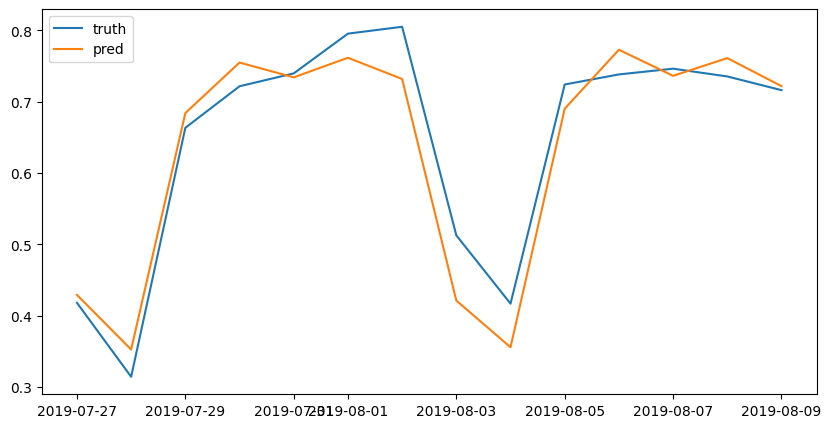

In [224]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(rail_test.iloc[56:56+14],label='truth')
ax.plot(
    pd.Series(
    prediction[-1, -1, :].detach().cpu().numpy(),
    index = rail_test.iloc[56:56+14].index
),label='pred'
)
ax.legend()

In [211]:
prediction[-1, -1, :].detach().cpu().numpy().shape

(14,)

In [212]:
pd.Series(
    prediction[-1, -1, :].detach().cpu().numpy(),
    index = rail_valid.iloc[56:56+14].index
)

date
2019-02-26    0.709984
2019-02-27    0.729437
2019-02-28    0.742834
2019-03-01    0.694376
2019-03-02    0.390395
2019-03-03    0.273050
2019-03-04    0.637456
2019-03-05    0.712779
2019-03-06    0.750573
2019-03-07    0.757194
2019-03-08    0.718573
2019-03-09    0.380624
2019-03-10    0.296695
2019-03-11    0.663787
dtype: float32